# Basics of running simulations in Jaxley

In this tutorial, you will learn how to:

- build your first morphologically detailed cell or read it from SWC  
- stimulate the cell  
- record from the cell  
- visualize cells  
- run your first simulation  

Here is a code snippet which you will learn to understand in this tutorial:
```python
import jaxley as jx
from jaxley.channels import Na, K, Leak
import matplotlib.pyplot as plt


# Build the cell.
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)
cell = jx.Cell(branch, parents=[-1, 0, 0, 1, 1])

# Insert channels.
cell.insert(Leak())
cell.branch(0).insert(Na())
cell.branch(0).insert(K())

# Visualize the morphology.
cell.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)

# Stimulate.
current = jx.step_current(i_delay=1.0, i_dur=1.0, i_amp=0.1, delta_t=0.025, t_max=10.0)
cell.branch(0).loc(0.0).stimulate(current)

# Record.
cell.branch(0).loc(0.0).record("v")

# Simulate and plot.
v = jx.integrate(cell)
plt.plot(v.T)
```

First, we import the relevant libraries:

In [69]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect

We will now build our first cell in `Jaxley`. You have two options to do this: you can either build a cell bottom-up by defining the morphology yourselve, or you can [load cells from SWC files]().


### Define the cell from scratch

To define a cell from scratch you first have to define a single compartment and then assemble those compartments into a branch:

In [70]:
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=4)

Next, we can assemble branches into a cell. To do so, we have to define for each branch what its parent branch is. A `-1` entry means that this branch does not have a parent.

In [81]:
parents = jnp.asarray([-1, 0, 0, 1, 1])
cell = jx.Cell(branch, parents=parents)

### Read the cell from an SWC file

Alternatively, you could also load cells from SWC with 

```cell = jx.read_swc(fname, nseg=4)```.

### Visualize the cells

Cells can be visualized as follows:

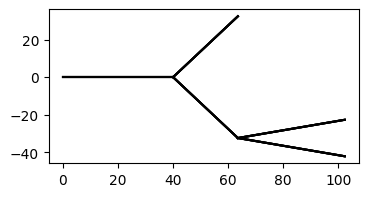

In [82]:
cell.compute_xyz()  # Only needed for visualization.

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = cell.vis(ax=ax, col="k")

### Insert mechanisms

Currently, the cell does not contain any kind of ion channel (not even a `leak`). We can fix this by inserting a leak channel into the entire cell, and by inserting sodium and potassium into the zero-eth branch.

In [73]:
cell.insert(Leak())
cell.branch(0).insert(Na())
cell.branch(0).insert(K())

The easiest way to know which branch is the zero-eth branch (or, e.g., the zero-eth compartment of the zero-eth branch) is to plot it in a different color:

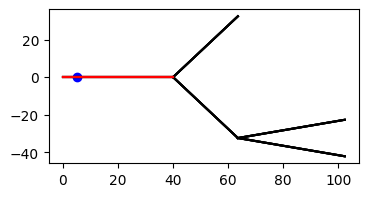

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = cell.vis(ax=ax, col="k")
_ = cell.branch(0).vis(ax=ax, col="r")
_ = cell.branch(0).loc(0.0).vis(ax=ax, col="b")

### Stimulate the cell

We next stimulate one of the compartments with a step current. For this, we first define the step current (all units are the same as for the `NEURON` simulator, which are listed [here](https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html)):

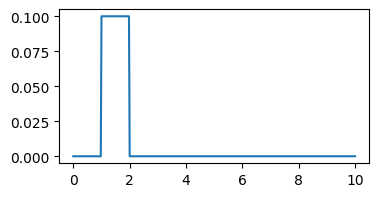

In [75]:
dt = 0.025
t_max = 10.0
time_vec = np.arange(0, t_max+dt, dt)
current = jx.step_current(i_delay=1.0, i_dur=1.0, i_amp=0.1, delta_t=dt, t_max=t_max)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = plt.plot(time_vec, current)

We then stimulate one of the compartments of the cell with this step current:

In [76]:
cell.delete_stimuli()
cell.branch(0).loc(0.0).stimulate(current)

Added 1 external_states. See `.externals` for details.


### Define recordings

Next, you have to define where to record the voltage. In this case, we will record the voltage at two locations:

In [77]:
cell.delete_recordings()
cell.branch(0).loc(0.0).record("v")
cell.branch(3).loc(1.0).record("v")

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


We can again visualize these locations to understand where we inserted recordings:

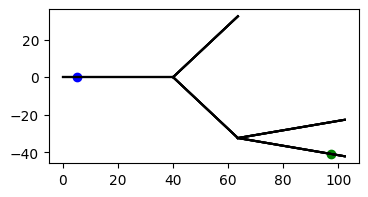

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = cell.vis(ax=ax)
_ = cell.branch(0).loc(0.0).vis(ax=ax, col="b")
_ = cell.branch(3).loc(1.0).vis(ax=ax, col="g")

### Simulate the cell response

Having set up the cell, inserted stimuli and recordings, we are now ready to run a simulation with `jx.integrate`:

In [79]:
voltages = jx.integrate(cell)
print("voltages.shape", voltages.shape)

voltages.shape (2, 402)


The `jx.integrate` function returns an array of shape `(num_recordings, num_timepoints). In our case, we inserted `2` recordings and we simulated for 10ms at a 0.025 time step, which leads to 402 time steps.

We can now visualize the voltage response:

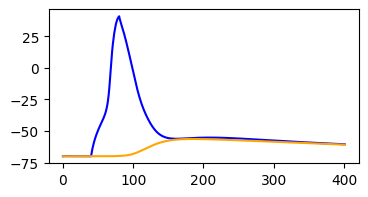

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(voltages[0], c="b")
_ = ax.plot(voltages[1], c="orange")

At the location of the first recording (in blue) the cell spiked, whereas at the second recording, it did not. This makes sense because we only inserted sodium and potassium channels into the first branch, but not in the entire cell.

Congrats! You have just run your first morphologically detailed neuron simulation in `Jaxley`. We suggest to continue by learning how to [build networks](https://jaxleyverse.github.io/jaxley/tutorial/02_small_network/). If you are only interested in single cell simulations, you can directly jump to learning how to [modify parameters of your simulation](https://jaxleyverse.github.io/jaxley/tutorial/03_setting_parameters/). If you want to simulate detailed morphologies from SWC files, checkout our tutorial on [working with detailed morphologies](https://jaxleyverse.github.io/jaxley/tutorial/08_importing_morphologies/).